<a href="https://colab.research.google.com/github/panchrissantfdz/Analisis-de-Imagenes-CIC-IPN/blob/main/ResNet_Pytorch_Christian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade torch torchvision

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuración inicial
img_width, img_height = 200, 100
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/Imágenes Ordenadas/Mas40/Entrenamiento'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/Imágenes Ordenadas/Mas40/Validación'
nb_train_samples = 255
nb_validation_samples = 51
epochs = 30
batch_size = 8

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(degrees=(0, 30)),# Rotación aleatoria entre 0 y 30 grados
    transforms.RandomEqualize(), # Ajuste de brillo aleatorio (Equalize)
    transforms.RandomAdjustSharpness(sharpness_factor=2),# Ajuste de nitidez aleatorio con un factor de 2
    transforms.RandomHorizontalFlip(),# Volteo horizontal aleatorio con una probabilidad del 50%
    transforms.RandomVerticalFlip(),# Volteo vertical aleatorio con una probabilidad del 50%


    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])




In [ ]:

validation_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets y DataLoaders
train_dataset = datasets.ImageFolder(train_data_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(validation_data_dir, transform=validation_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

# Definición del modelo basado en ResNet
class ResNetCustom(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetCustom, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [ ]:

# Entrenamiento del modelo
model = ResNetCustom().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stopping = EarlyStopping(patience=5, delta=0.001)

tiempo_inicial = time.time()
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_accuracies.append(train_acc)

#Cambiar ------------------------

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    early_stopping(val_acc, model)
    if early_stopping.best_model_state is not None:
        torch.save(model.state_dict(), 'best_model.pth')

early_stopping.load_best_model(model)

# Tiempo de ejecución
tiempo_final = time.time()
print(f"Tiempo de ejecución: {tiempo_final - tiempo_inicial:.2f} segundos")

#Cambiar ------------------------

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.1MB/s]


Epoch [1/30], Train Accuracy: 0.8644, Validation Accuracy: 1.0000
Epoch [2/30], Train Accuracy: 0.9774, Validation Accuracy: 1.0000
Epoch [3/30], Train Accuracy: 0.9887, Validation Accuracy: 1.0000
Epoch [4/30], Train Accuracy: 0.9944, Validation Accuracy: 1.0000
Epoch [5/30], Train Accuracy: 0.9887, Validation Accuracy: 1.0000
Epoch [6/30], Train Accuracy: 0.9944, Validation Accuracy: 1.0000
Epoch [7/30], Train Accuracy: 0.9944, Validation Accuracy: 1.0000
Epoch [8/30], Train Accuracy: 0.9718, Validation Accuracy: 1.0000
Epoch [9/30], Train Accuracy: 0.9887, Validation Accuracy: 1.0000
Epoch [10/30], Train Accuracy: 0.9887, Validation Accuracy: 1.0000
Epoch [11/30], Train Accuracy: 0.9944, Validation Accuracy: 1.0000
Epoch [12/30], Train Accuracy: 0.9774, Validation Accuracy: 1.0000
Epoch [13/30], Train Accuracy: 0.9831, Validation Accuracy: 1.0000
Epoch [14/30], Train Accuracy: 0.9944, Validation Accuracy: 1.0000
Epoch [15/30], Train Accuracy: 0.9718, Validation Accuracy: 1.0000
Epoc

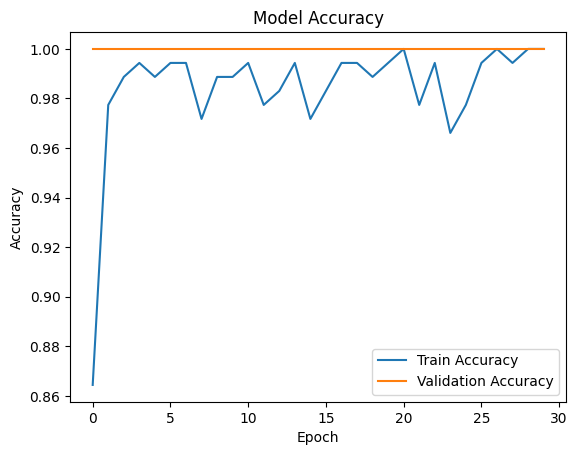

In [ ]:
# Curvas de aprendizaje
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#/////////////////////////////////////////////
#
# Guardar el modelo
#
#////////////////////////////////////////////

model_path = '/content/drive/MyDrive/Colab Notebooks/VGG16_prueba5.pth'
torch.save(model.state_dict(), model_path)  # Guardar los pesos del modelo
print(f"Modelo guardado en {model_path}")


Modelo guardado en /content/drive/MyDrive/Colab Notebooks/VGG16_prueba5.pth


In [ ]:
print("Clases detectadas por ImageFolder:", train_dataset.classes)
print("Clases detectadas por ImageFolder:", validation_dataset.classes)

Clases detectadas por ImageFolder: ['DR', 'HR', 'WNL']
Clases detectadas por ImageFolder: ['DR', 'HR', 'WNL']


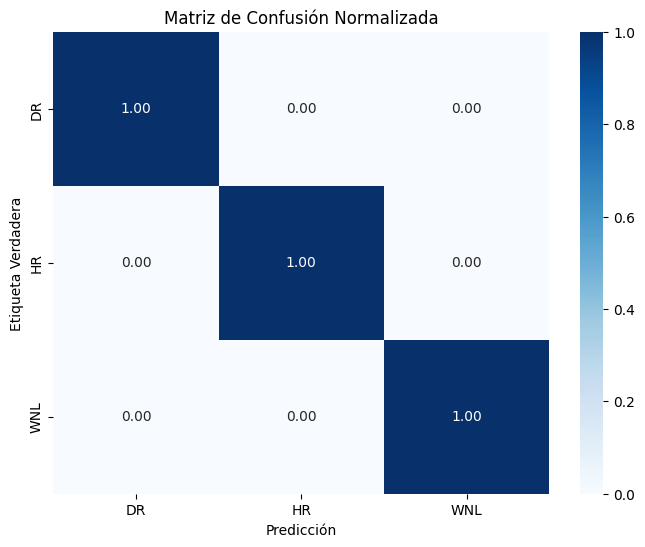

Final Validation Accuracy: 1.0000


In [ ]:

# Matriz de Confusión
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=train_dataset.classes, columns=train_dataset.classes)
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matriz de Confusión Normalizada")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Predicción")
plt.show()

print(f"Final Validation Accuracy: {np.trace(cf_matrix) / np.sum(cf_matrix):.4f}")
